#### Model training and evaluation for age group less than 25 with extra feature (group with high errors): 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

<h2 align="center" style="color:blue">Data Loading</h2>

In [5]:
df = pd.read_excel('premiums_young_with_gr.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [6]:
print("Rows and Columns in the Dataset")
print(df.shape)

Rows and Columns in the Dataset
(20096, 14)


In [7]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [8]:
print("Missing values in the dataset")
df.isna().sum()

Missing values in the dataset


age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [9]:
print("Dropping the missing values")
df.dropna(inplace=True)
df.isna().sum()

Dropping the missing values


age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### Handle Duplicates

In [10]:
df.duplicated().sum()

0

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [12]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### Data Cleaning: number_of_dependants

We can see some negative values in number_of_dependants. We can replace them with positive numbers

In [13]:
print(df.query('number_of_dependants < 0')['number_of_dependants'].count())
print(df.query('number_of_dependants < 0')['number_of_dependants'].unique())

22
[-3 -1]


In [14]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [15]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

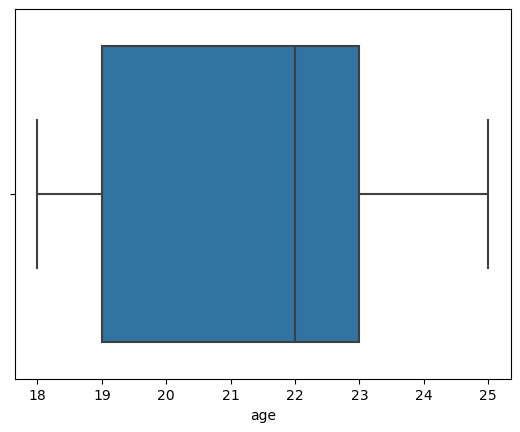

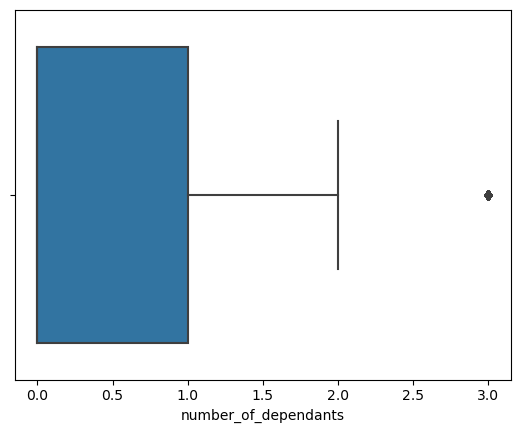

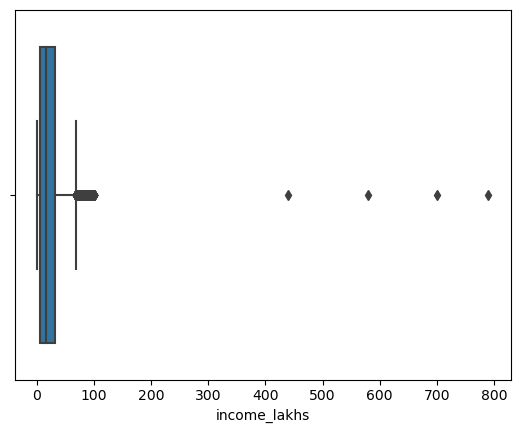

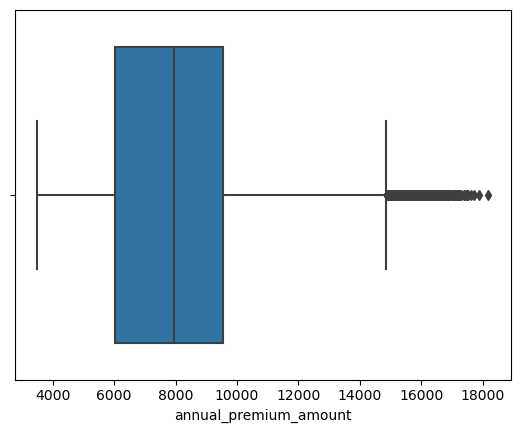

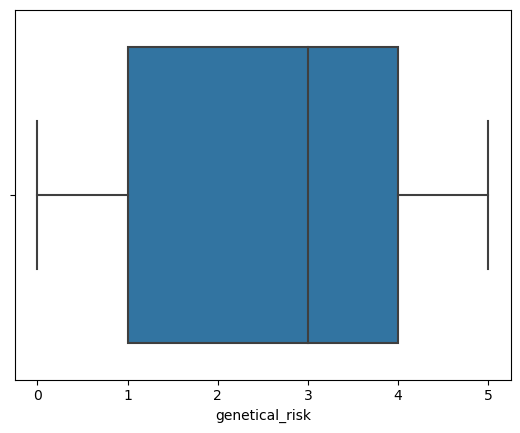

In [16]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()    

### Outlier Treatment: Age Column

In [17]:
# df[df['age']>100]['age'].unique()
df.query('age > 100')['age'].unique()

array([], dtype=int64)

In [18]:
# df1 = df[df.age<=100]

df1 = df.query('age <= 100').copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### Outlier Treatment: Income Column

In [19]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [20]:
df1[df1.income_lakhs>upper].count()

age                      1295
gender                   1295
region                   1295
marital_status           1295
number_of_dependants     1295
bmi_category             1295
smoking_status           1295
employment_status        1295
income_level             1295
income_lakhs             1295
medical_history          1295
insurance_plan           1295
annual_premium_amount    1295
genetical_risk           1295
dtype: int64

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [21]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

100.0

In [22]:
df1[df1['income_lakhs'] > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636,3
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888,5
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424,3
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586,0


In [23]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(4, 14)

In [24]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


In [25]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

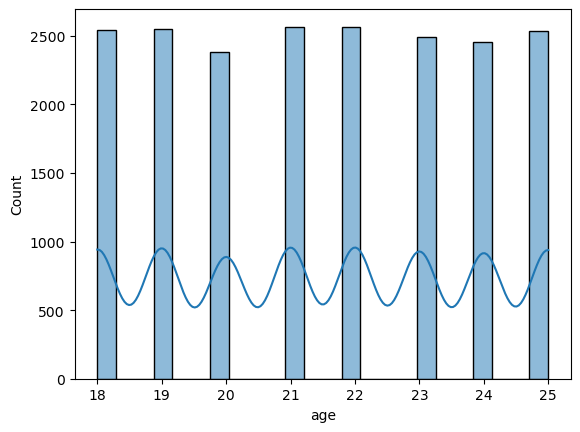

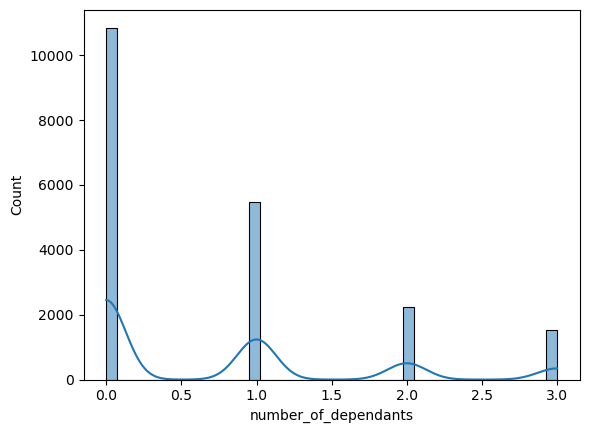

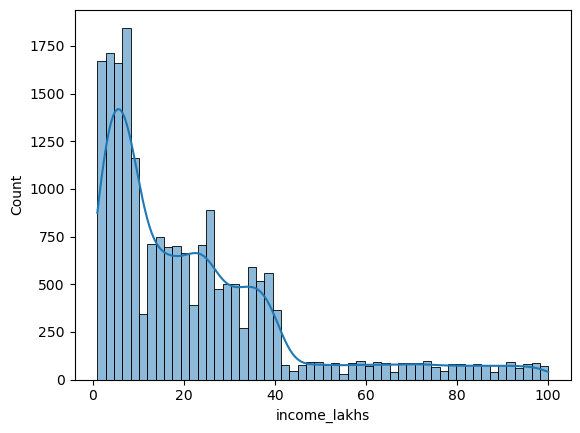

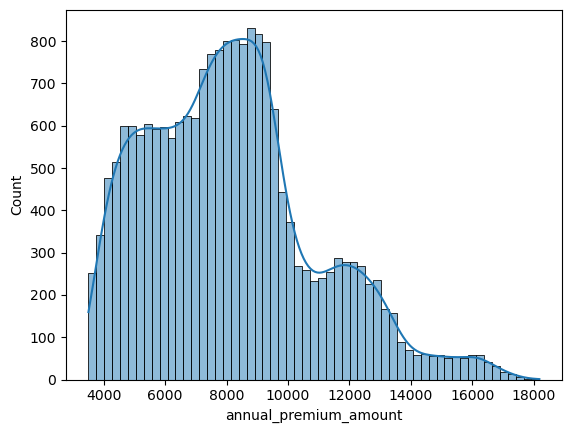

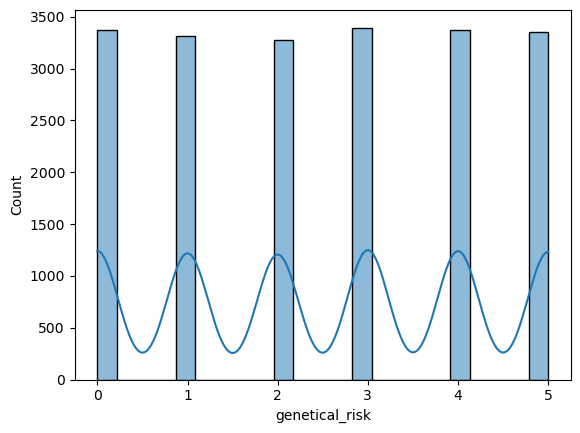

In [26]:
for col in numeric_columns:
    sns.histplot(df2[col],kde=True)
    plt.show()

### Bivariate Analysis: Numeric Columns

In [ ]:
numeric_columns

In [ ]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [27]:
categorical_col = df2.select_dtypes(exclude=['int64','float64'])
categorical_col

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northeast,Unmarried,Overweight,Regular,Self-Employed,> 40L,High blood pressure,Silver
1,Female,Northwest,Unmarried,Underweight,No Smoking,Freelancer,<10L,No Disease,Silver
2,Female,Southeast,Unmarried,Normal,Regular,Salaried,> 40L,No Disease,Silver
3,Male,Southeast,Unmarried,Normal,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
4,Male,Southeast,Unmarried,Overweight,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
...,...,...,...,...,...,...,...,...,...
20091,Female,Southeast,Unmarried,Underweight,No Smoking,Freelancer,> 40L,No Disease,Gold
20092,Female,Northwest,Unmarried,Obesity,Occasional,Freelancer,> 40L,Diabetes,Gold
20093,Female,Northwest,Unmarried,Underweight,No Smoking,Self-Employed,25L - 40L,No Disease,Bronze
20094,Male,Northwest,Unmarried,Normal,Regular,Freelancer,25L - 40L,No Disease,Bronze


In [28]:
for col in categorical_col:
     print(col,':',df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [29]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\1981040169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['smoking_status'].replace({


In [30]:
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Bivariate Analysis

In [31]:
print(df2['gender'].value_counts())
print(df2['gender'].value_counts(normalize=True))

gender
Male      11055
Female     9031
Name: count, dtype: int64
gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64


In [32]:
pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

In [33]:
# fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
# axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

# for ax, column in zip(axes, categorical_col):
#     # Calculate the percentage distribution of each category
#     category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
#     # Plotting the distribution using barplot
#     sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
#     ax.set_title(f'Percentage Distribution of {column}')
#     ax.set_ylabel('Percentage of Policyholders (%)')
#     ax.set_xlabel(column)  # Set xlabel to the column name for clarity

# plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
# plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


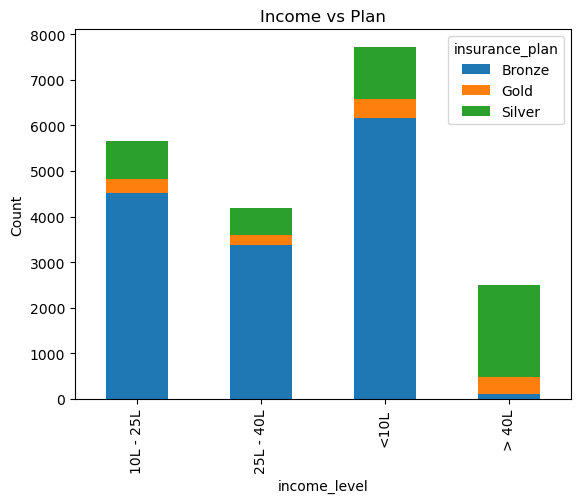

In [34]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

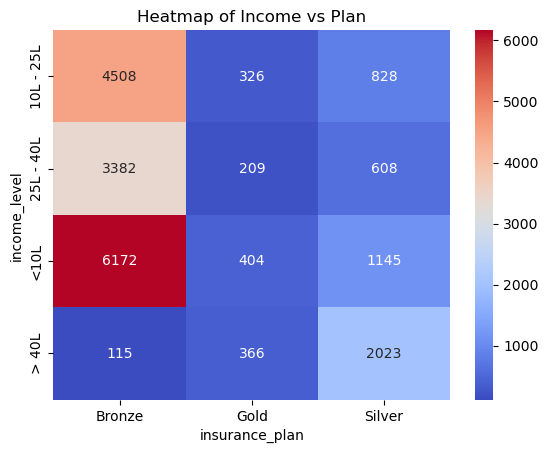

In [35]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:blue">Feature Engineering</h2>

### Calculate Risk Score

In [36]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [37]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\59644619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\59644619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\596446

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### Encode Text Columns

In [39]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


In [40]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.head(2)

C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\1028507126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,2,11050,3,no disease,none,0,0.000000


In [41]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [42]:
# Clean and standardize the column
df2['income_level'] = df2['income_level'].str.strip()  # Remove extra spaces if any

# Map the values
mapping = {'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4}
df2['income_level'] = df2['income_level'].map(mapping)

# Check for any unmapped values
print(df2['income_level'].isna().sum())


0


C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\2427633508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['income_level'] = df2['income_level'].str.strip()  # Remove extra spaces if any
C:\Users\adinr\AppData\Local\Temp\ipykernel_14380\2427633508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['income_level'] = df2['income_level'].map(mapping)


In [43]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [44]:
nominal_columns = ['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3 = pd.get_dummies(df2,columns=nominal_columns,drop_first=True,dtype=int)
df3.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0


### Feature Selection

In [45]:
df4 = df3.drop(columns=['medical_history','disease1','disease2','total_risk_score'])
df4.head(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Calculate VIF for Multicolinearity

In [46]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

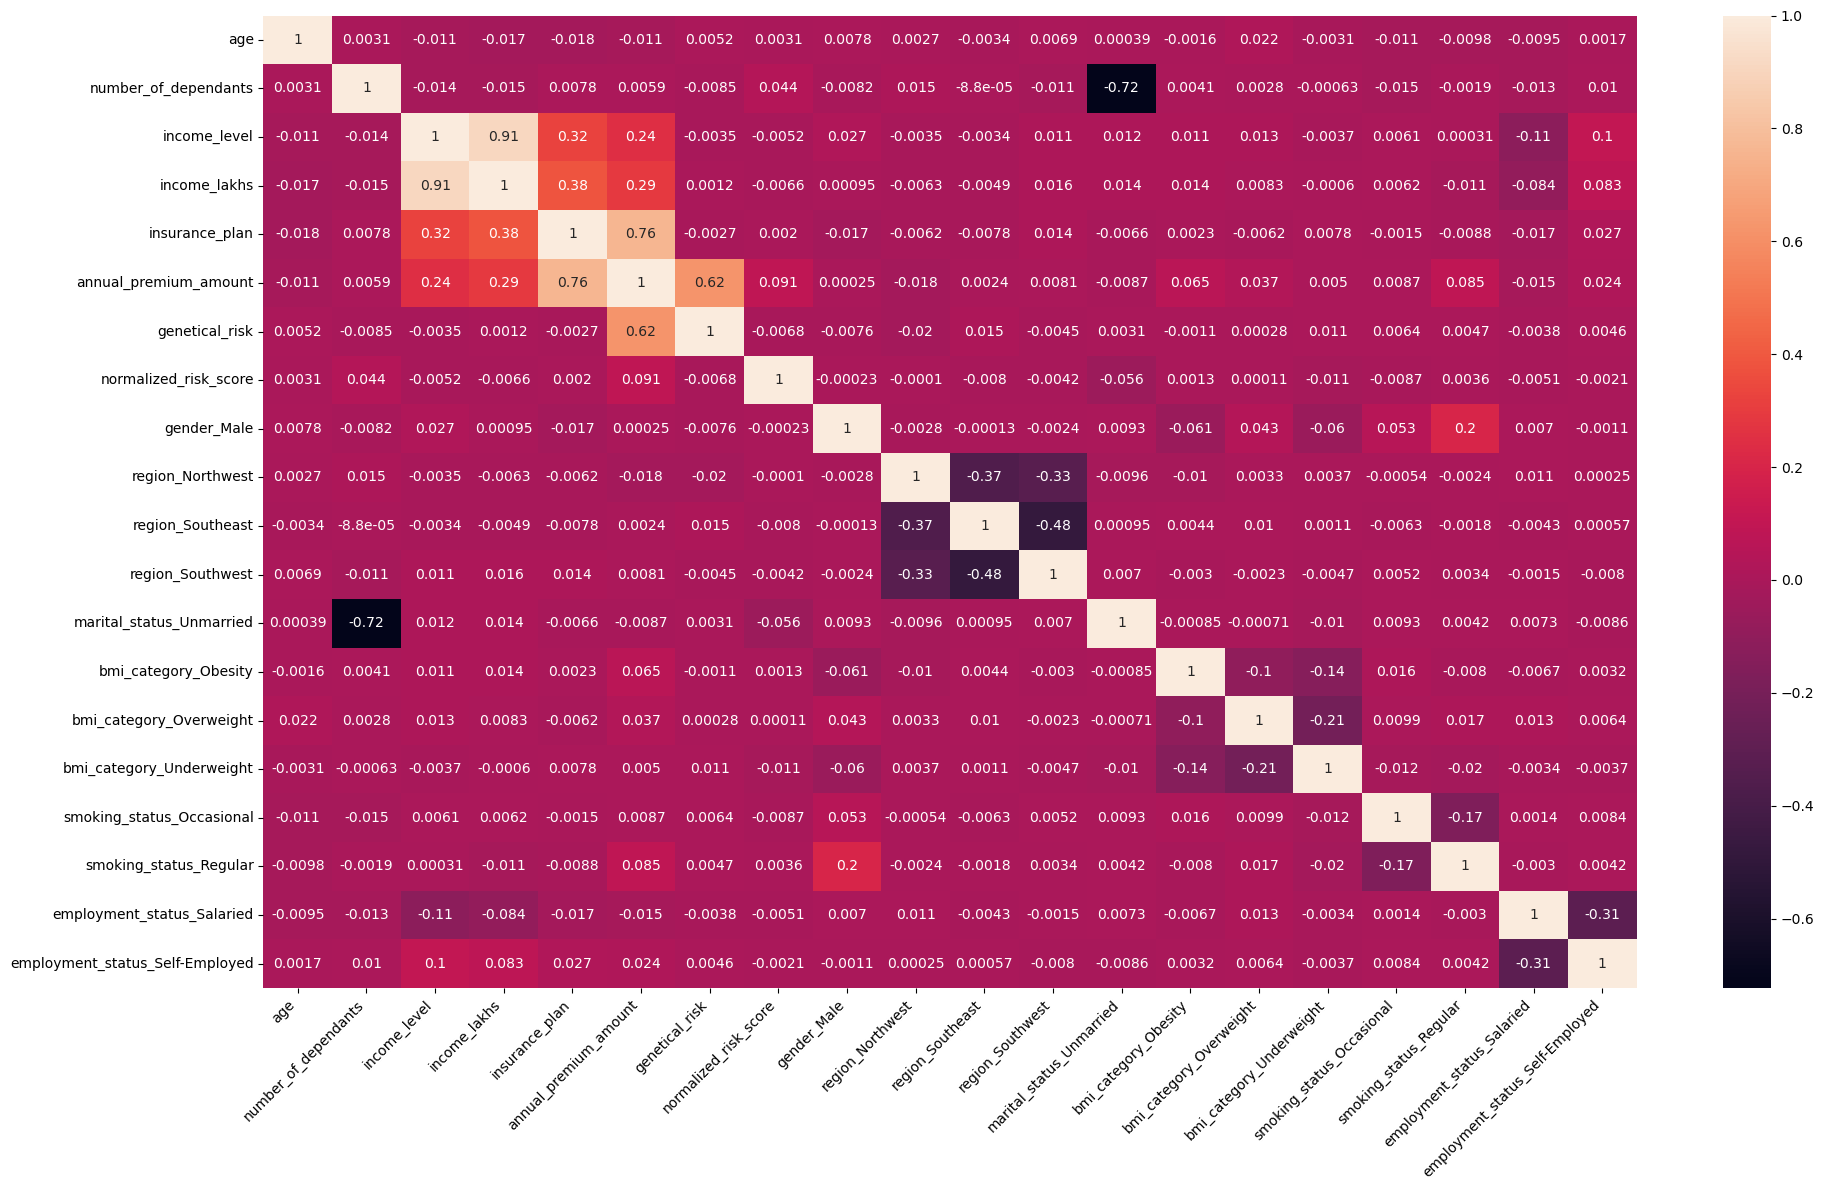

In [47]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
df4.head(1)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [88]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan','genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,1.0,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.0,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.0,1.0,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [90]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [91]:
calculate_vif(X.drop('income_level',axis='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [92]:
X_reduced = X.drop('income_level',axis='columns')
X_reduced.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


<h2 align="center" style="color:blue">Model Training</h2>

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X_reduced,y,test_size=0.30,random_state=10)

print("X train",X_train.shape)
print("X test",X_test.shape)
print("y train",y_train.shape)
print("y test",y_test.shape)

X train (14060, 18)
X test (6026, 18)
y train (14060,)
y test (6026,)


### Linear Regression Model

In [94]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

test_score = model_lr.score(X_test,y_test)
train_score = model_lr.score(X_train,y_train)

print(f"Train Score = {train_score}")
print(f"Test Score = {test_score}")

Train Score = 0.988297900194864
Test Score = 0.9887263253056615


In [95]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.4,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [96]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print(f"Mean squared error (Linear R) = {mse_lr}")
print(f"Root mean squared error (Linear R) = {rmse_lr}")

Mean squared error (Linear R) = 85732.3437793045
Root mean squared error (Linear R) = 292.8008602776032


In [97]:
model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

In [98]:
model_lr.intercept_

3978.823528438257

In [99]:
feature_importances = model_lr.coef_

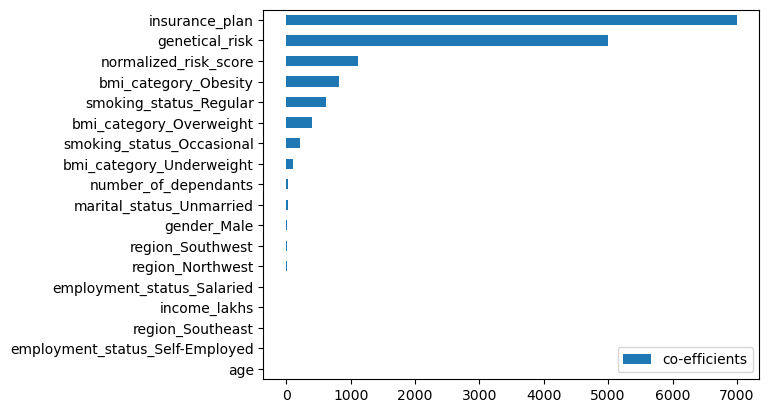

In [100]:
coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['co-efficients'])
coef_df.sort_values(by='co-efficients').plot(kind='barh')
plt.show()

### Ridge Regression Model

In [101]:
model_r = Ridge()
model_r.fit(X_train,y_train)

test_score = model_r.score(X_test,y_test)
train_score = model_r.score(X_train,y_train)

print(f"Train Score = {train_score}")
print(f"Test Score = {test_score}")

Train Score = 0.9882972960153418
Test Score = 0.9887275909694276


### XGBoost 

In [102]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)

test_score = model_xgb.score(X_test,y_test)
train_score = model_xgb.score(X_train,y_train)

print(f"Train Score = {train_score}")
print(f"Test Score = {test_score}")

Train Score = 0.9925054809841402
Test Score = 0.987729520869432


In [103]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test,y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print(f"Mean squared error (XGB) = {mse_xgb}")
print(f"Root mean squared error (XGB) = {rmse_xgb}")

Mean squared error (XGB) = 93312.69206188193
Root mean squared error (XGB) = 305.4712622520847


In [104]:
param_grid = {
    'n_estimators': [20, 40,50,],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3 ,4, 5],
}

random_search = RandomizedSearchCV(model_xgb,param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)

random_search.fit(X_train, y_train)

print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best Parameters:  {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Best Score:  0.9879225990497197


In [108]:
best_model = model_lr
best_model

LinearRegression()

In [111]:
# best_model.feature_names_in_

array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype=object)

In [ ]:
# coef_df = pd.DataFrame(best_model.feature_importances_,index=X_test.columns,columns=['co-efficients'])
# coef_df.sort_values(by='co-efficients').plot(kind='barh')
# plt.show()

### Error Analysis

In [112]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals *100 /y_test

results_df = pd.DataFrame(
{
    'actual_value':y_test,
    'predicted':y_pred,
    'residuals':residuals,
    'residuals_pct':residuals_pct
})

results_df.head()

,actual_value,predicted,residuals,residuals_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


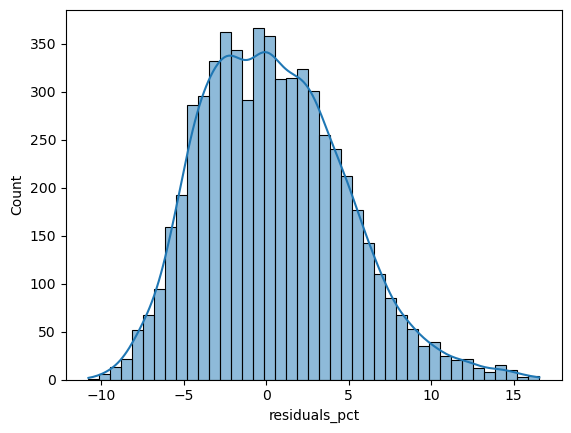

In [70]:
sns.histplot(results_df,x='residuals_pct',kde=True)
plt.show()

In [113]:
extreme_threshold = 10 

extreme_results_df = results_df[np.abs(results_df['residuals_pct']) > extreme_threshold]
extreme_results_df.head(3)
print(extreme_results_df.shape)

(129, 4)


In [114]:
results_df.shape

(6026, 4)

In [115]:
extreme_results_df.shape[0] * 100 / results_df.shape[0]

2.140723531364089

In [116]:
results_df[np.abs(results_df['residuals_pct']) > 50].sort_values('residuals_pct',ascending=False)
# We have 549 rows with more tha 50% error margin.

,actual_value,predicted,residuals,residuals_pct


In [119]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [120]:
extreme_results_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [121]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(5)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


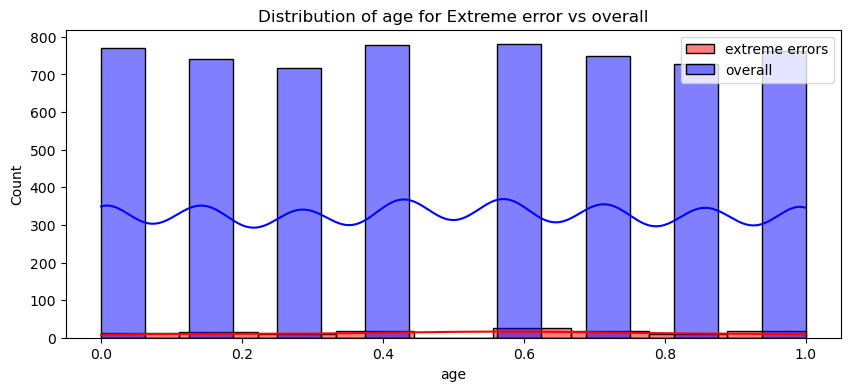

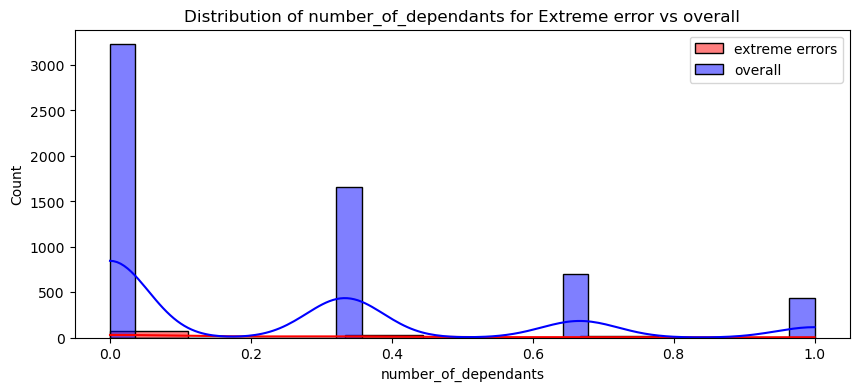

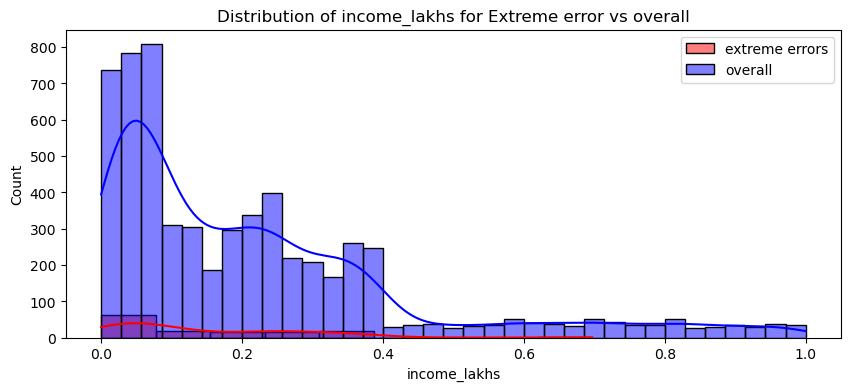

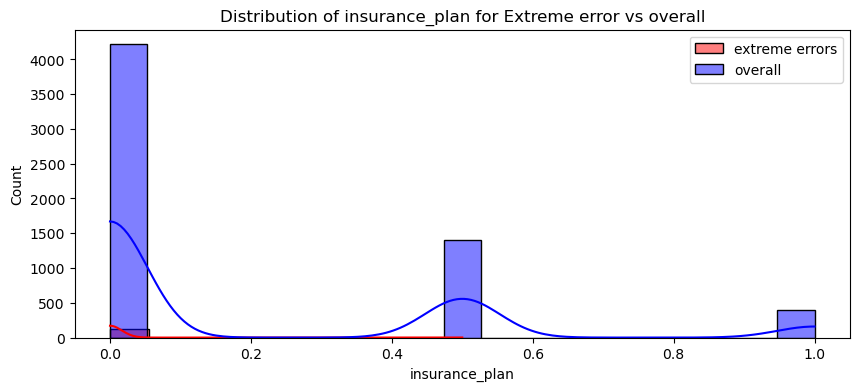

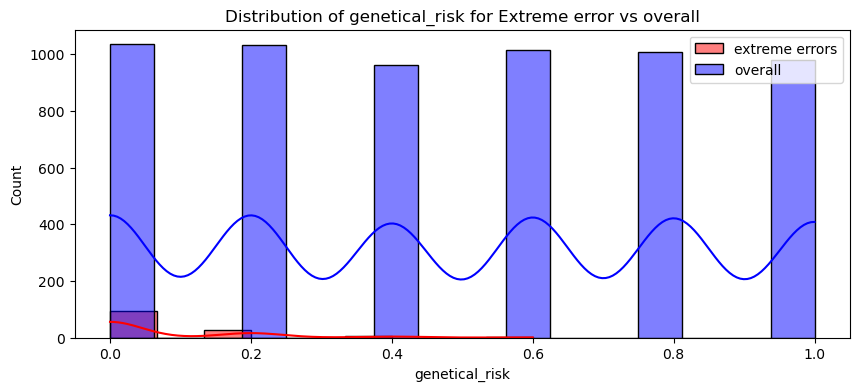

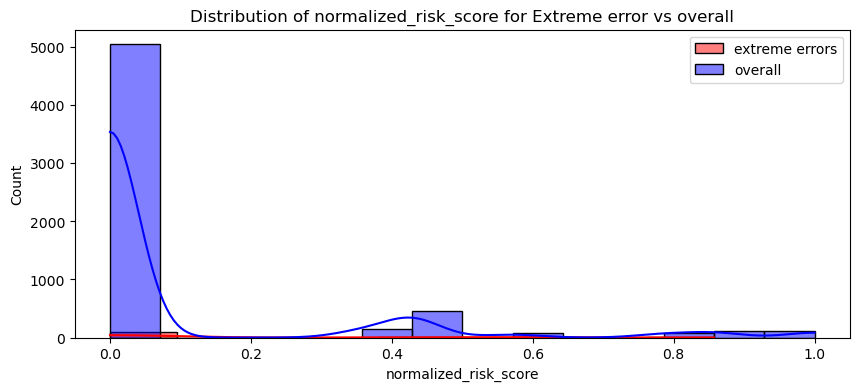

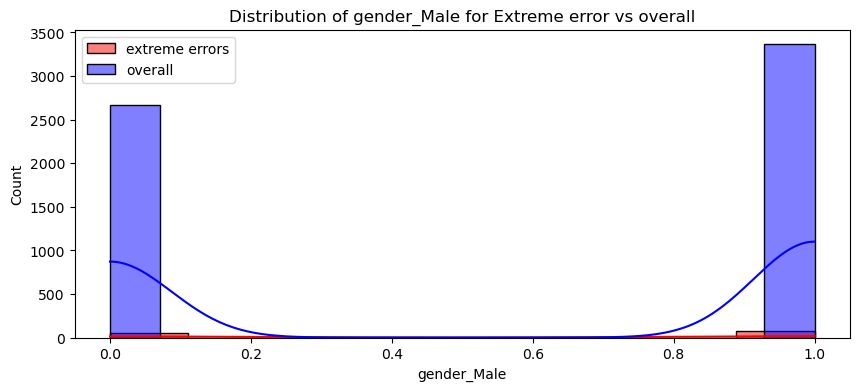

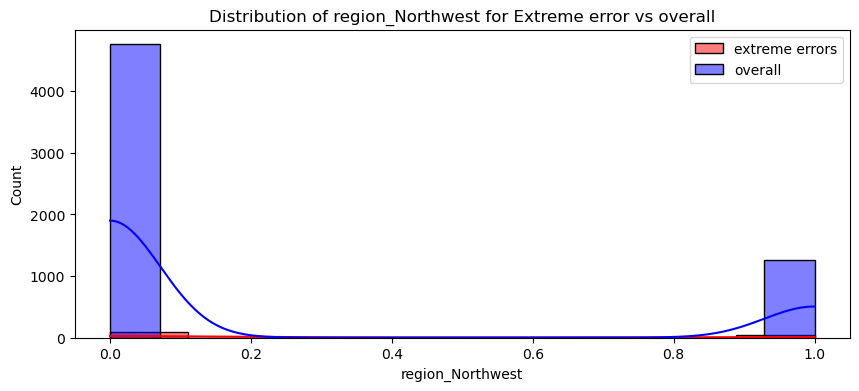

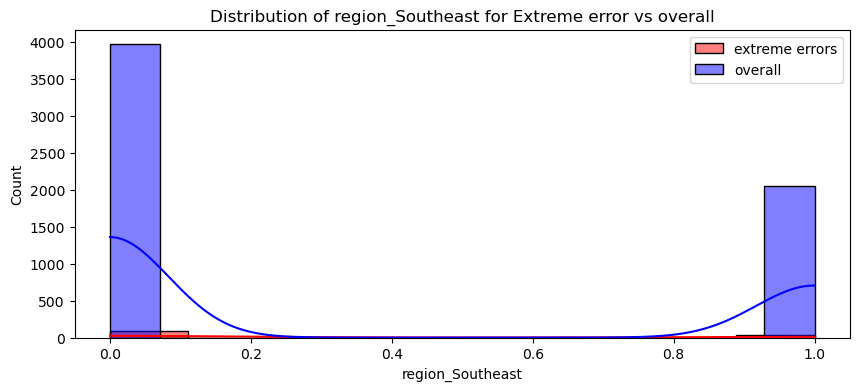

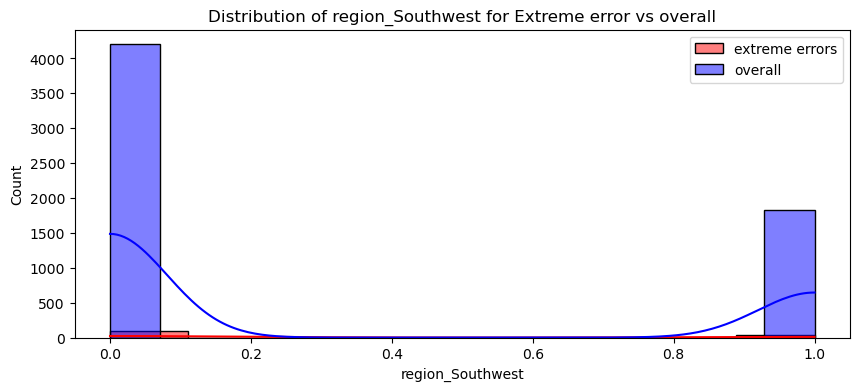

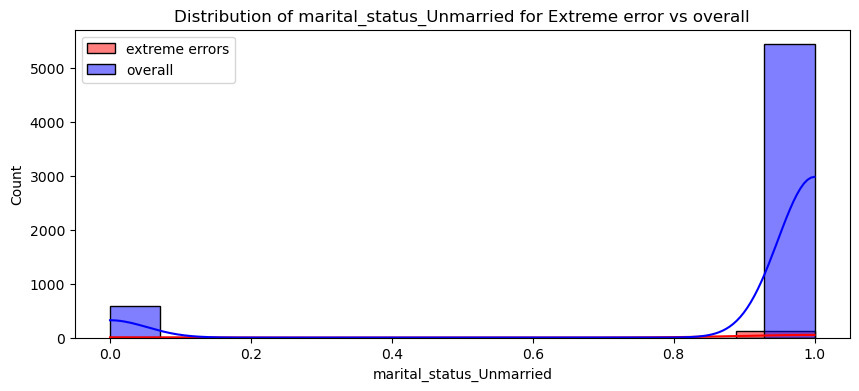

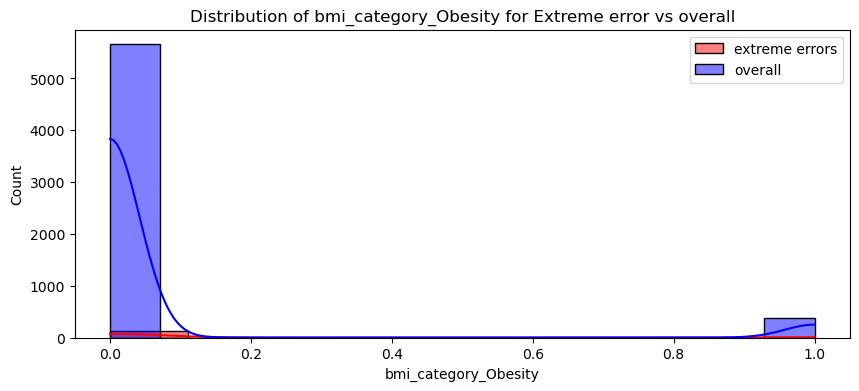

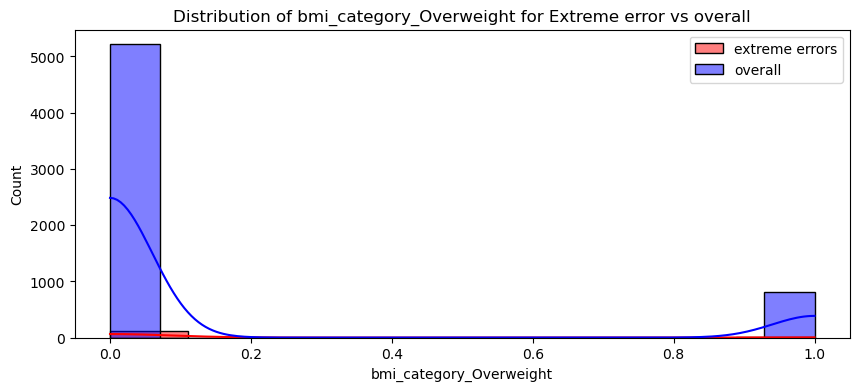

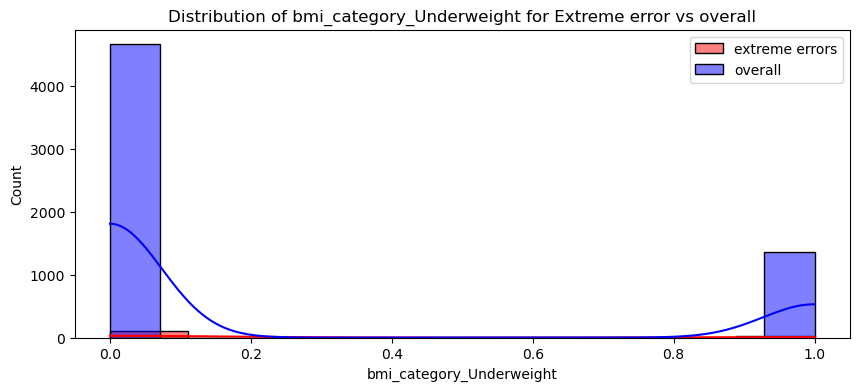

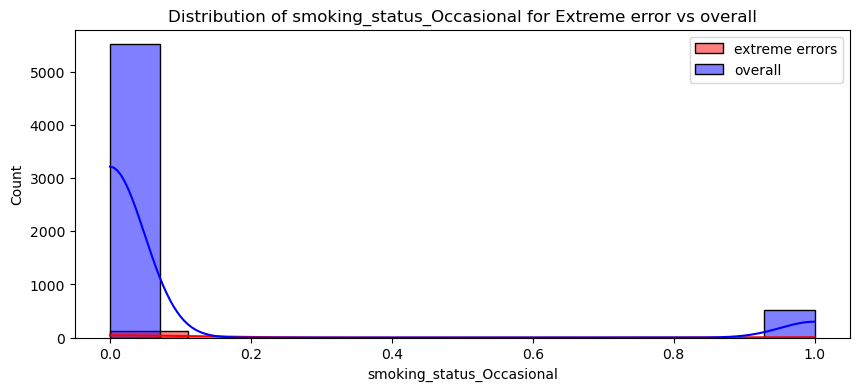

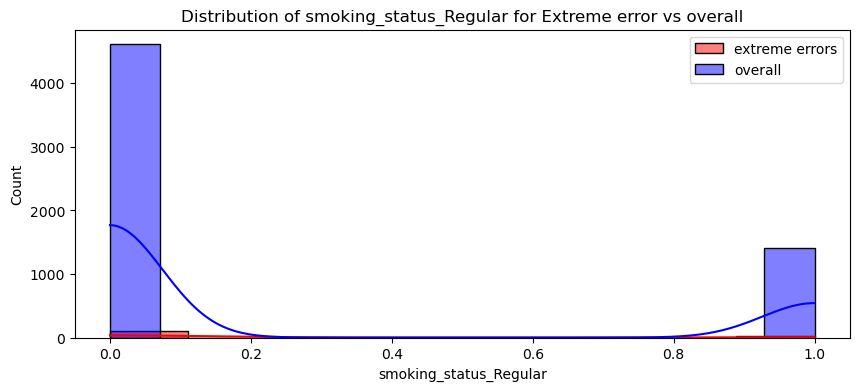

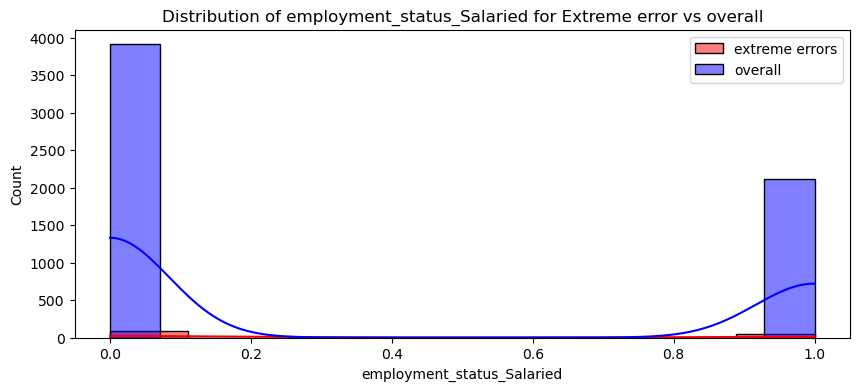

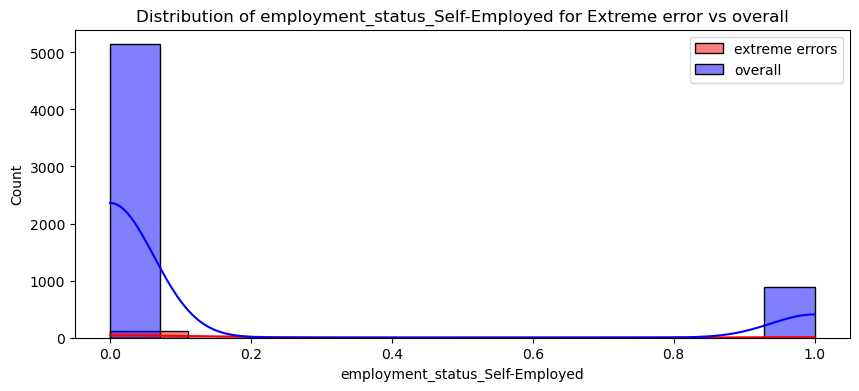

In [122]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature],color='red',label='extreme errors',kde=True)
    sns.histplot(X_test[feature],color='blue',label='overall',kde=True)
    plt.title(f'Distribution of {feature} for Extreme error vs overall')
    plt.legend()
    plt.show()

In [123]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

In [126]:
extreme_errors_df.head(3)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.0,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.0,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.0,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0


### Export the Model

In [130]:
from joblib import dump

dump(best_model,"artifacts/model_young.joblib")

['artifacts/model_young.joblib']

In [132]:
dump(scaler_with_cols,"artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']

In [131]:
scaler_with_cols = {
    'scaler':scaler,
    'cols_to_scale':cols_to_scale
}
scaler_with_cols

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'income_level',
  'income_lakhs',
  'insurance_plan',
  'genetical_risk']}